# Test Tensorflow / Keras Models
This notebook tests some machine learning on fitted TES data using Keras and Tensorflow

In [1]:
import numpy as np
import glob
import os
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.ml import MLHyperParTuning, significance
from fastespy.analysis import init_logging
from pathlib import PosixPath
import logging

import sys
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

In [2]:
%matplotlib inline

## Read data 

In [3]:
path = "/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/"
in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
files

8


['/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-4-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-2-triggertimefixed.pickle.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-36hrs-1-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/newsettings-0.3RN-1.5GHzGBWP-50MHz-20mV-light-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-5-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-24hrs-1-triggertimefixed.npy',
 '/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-3-triggertimefixed.pickl

In [4]:
init_logging("INFO", color=True)

In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3942267661.py:   3 --- INFO: Using files:
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-4-triggertimefixed.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-2-triggertimefixed.pickle.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-36hrs-1-triggertimefixed.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/newsettings-0.3RN-1.5GHzGBWP-50MHz-20mV-light-triggertimefixed.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-5-triggertimefixed.npy
3942267661.py:   5 --- INFO: /Users/manuelmeyer/Download

In [6]:
y.copy()

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
X_log, y_log = MLHyperParTuning.transform_data_log(X.copy(), y.copy(), feature_names)

Discarded 89 triggers in log transform


/Users/manuelmeyer/Python/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


In [8]:
k_folds = 5
ml = MLHyperParTuning(X_log, y_log,
                      valid_fraction=1. / k_folds,
                      stratify=True,
                      random_state=42,
                      n_splits=k_folds)

# now test and train data are contained 
# in ml.X_test, ml.X_train, ml.y_test, and ml.y_train

To Do:
- produce confusion matrix
- check whether PCA improves things
- compare with sklearn results
- compare with previous data set
- more things to test: weighting, data augmentation, regularization with dropout?

In [9]:
x = ml._kf.split(ml.X_train, ml.y_train)

In [10]:
# generate train and validation set from stratified K fold

for train_index, val_index in ml._kf.split(ml.X_train, ml.y_train):
    X_train, y_train = ml.X_train[train_index], ml.y_train[train_index]
    X_val, y_val = ml.X_train[val_index], ml.y_train[val_index]
    
# check class proportion
print(y_train.sum() / y_train.size)
print(y_val.sum() / y_val.size)
print(y_train.size)
print(y_val.size)
print(ml.y_test.size)

0.23717571333254836
0.23724289527398335
25479
6369
7963


## Start with Keras and tensorflow

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [12]:
tf.__file__

'/Users/manuelmeyer/Python/miniforge3/envs/apple_tf/lib/python3.8/site-packages/tensorflow/__init__.py'

In [13]:
# normalize the input data
normalizer = Normalization(axis=-1)

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_val = normalizer(X_val)
X_test = normalizer(ml.X_test)

In [14]:
print(np.var(X_train, axis=0))
print(np.mean(X_train, axis=0))

[0.9999836  0.99999964 0.99999845 1.0000027  0.99999785 0.9999997
 0.9999974 ]
[ 3.4160090e-07  1.4319713e-07  9.0346219e-09  2.5350280e-07
 -3.0475826e-07  6.2180283e-09 -3.1405955e-07]


### Building a first simple DNN

In [15]:
# define different metrics
# see also https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

adam = keras.optimizers.Adam(learning_rate=3e-4)


In [16]:
# initializing the sequential model
def make_model(metrics=metrics, output_bias=None, n_layers=3, n_nodes=100, l2_regularizer=None):
    model = keras.Sequential(name="dnn_test")
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    if l2_regularizer is not None:
        l2_regularizer = keras.regularizers.l2(l2_regularizer)
    


    # adding the input layer
    model.add(keras.layers.Input(shape=(X_train.shape[1])))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(n_nodes,
                                     activation='relu',
                                     name='dense{0:n}'.format(i + 1),
                                     kernel_regularizer=l2_regularizer,
                                     bias_regularizer=l2_regularizer
                                    )
                 )
    
    # output
    model.add(keras.layers.Dense(1, activation='sigmoid', name='output',
                                 bias_initializer=output_bias)) # output layer for binary classification
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=adam,
        metrics=metrics
    )
    
    return model

In [17]:
n_nodes = 100
n_layers = 3
l2_regularizer = None

In [18]:
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer)

In [19]:
model.output_shape

(None, 1)

In [20]:
model.summary()

Model: "dnn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               800       
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________


In [21]:
EPOCHS = 100
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

# early stopping if loss of validation set does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [22]:
# test the model
model.predict(X_train[:10])

2021-08-18 14:44:51.637313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-18 14:44:51.637580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x159868280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[0.18107492],
       [0.17306004],
       [0.18758738],
       [0.20465091],
       [0.18627834],
       [0.1925139 ],
       [0.19585645],
       [0.19004671],
       [0.1881411 ],
       [0.1996908 ]], dtype=float32)

In [23]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x158cf0dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
# check the loss. if initial bias is correct, you should get something of the order of
# -ln(1 / n_classes) = ln(2)
print(np.log(2.), results['loss'])

0.6931471805599453 0.547373354434967


In [25]:
# compute initial bias
initial_bias = np.array([np.log(y_train.sum() / np.invert(y_train.astype(np.bool)).astype(np.int).sum())])
print(initial_bias)
print(y_train.sum() / np.invert(y_train.astype(np.bool)).astype(np.int).sum())

[-1.16822644]
0.3109178843383412


/var/folders/4h/qfkd75ns1vzg60n7w4jchlw40000gr/T/ipykernel_10891/1163674395.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  initial_bias = np.array([np.log(y_train.sum() / np.invert(y_train.astype(np.bool)).astype(np.int).sum())])
/var/folders/4h/qfkd75ns1vzg60n7w4jchlw40000gr/T/ipykernel_10891/1163674395.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

In [26]:
print(y_train.sum()/ y_train.size)

0.23717571333254836


In [27]:
model = make_model(output_bias=np.array([initial_bias]), n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer)

In [28]:
model.predict(X_train[:10])

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x15a0c98b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[0.26333526],
       [0.27177718],
       [0.26125655],
       [0.2931041 ],
       [0.26886198],
       [0.23374498],
       [0.2836312 ],
       [0.2877631 ],
       [0.29392058],
       [0.26418284]], dtype=float32)

In [29]:
p0 = 1. / (1. + np.exp(-initial_bias))
print (-p0 * np.log(p0) - (1. - p0) * np.log(1. - p0))

[0.54780251]


In [30]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
print(results['loss'])

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x15aadb040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.528437614440918


In [31]:
model.layers[-1].bias.value()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.1682265], dtype=float32)>

In [32]:
import tempfile
import os

Save the initial weights

In [33]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights_{n_layers}_{n_nodes}')
model.save_weights(initial_weights)

In [34]:
# check if new bias helps
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x15e43f280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x161387940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [35]:
# now with bias
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x15aacd550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x159b64700> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [36]:
# plot the results 
def plot_metric(history, metric="loss", **kwargs):
    label = kwargs.pop('label', '')
    plt.semilogy(history.epoch, history.history[metric], label='Train ' + label, **kwargs)
    
    kwargs.pop('ls', None)
    plt.semilogy(history.epoch, history.history[f'val_{metric}'], label='Val ' + label, ls='--', **kwargs)
    plt.xlabel('Epoch')
    plt.ylabel(metric)


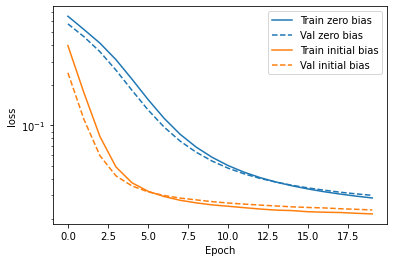

In [37]:
plot_metric(zero_bias_history, metric='loss', label='zero bias', color='C0')
plot_metric(careful_bias_history, metric='loss' , label='initial bias', color='C1')
plt.legend()

The initial bias seems to help slightly.

### Train the full model

In [38]:
# now with bias
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer)
model.summary()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val), 
    verbose=0
)


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x163f358b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "dnn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               800       
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 21,101
Trainable params: 21,101
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, deco

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x163f46af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-18 14:45:00.828832: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-18 14:45:00.828884: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-18 14:45:00.828907: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-18 14:45

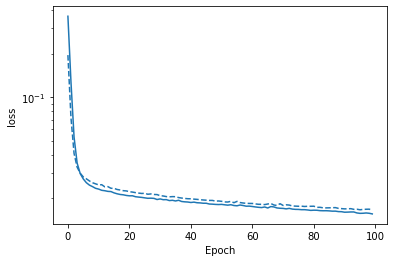

In [39]:
plot_metric(baseline_history, color="C0")

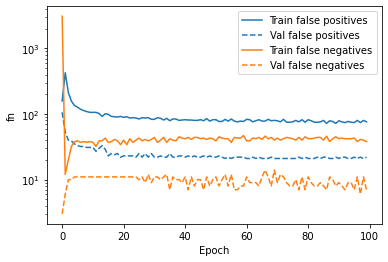

In [40]:
plot_metric(baseline_history, metric="fp", color="C0", label="false positives")
plot_metric(baseline_history, metric="fn", color="C1", label="false negatives")
plt.legend()

In [41]:
ml.y_test.sum() / ml.y_test.size

0.23722215245510486

In [42]:
test_scores = model.evaluate(X_test, ml.y_test, verbose=2, return_dict=True)
print("Test loss:", test_scores["loss"])
print("Test accuracy:", test_scores["accuracy"])
print(test_scores)

249/249 - 0s - loss: 0.0203 - tp: 1879.0000 - fp: 31.0000 - tn: 6043.0000 - fn: 10.0000 - accuracy: 0.9949 - precision: 0.9838 - recall: 0.9947 - auc: 0.9989 - prc: 0.9941
Test loss: 0.020334480330348015
Test accuracy: 0.9948511719703674
{'loss': 0.020334480330348015, 'tp': 1879.0, 'fp': 31.0, 'tn': 6043.0, 'fn': 10.0, 'accuracy': 0.9948511719703674, 'precision': 0.9837696552276611, 'recall': 0.9947062134742737, 'auc': 0.998934805393219, 'prc': 0.9940783977508545}


In [55]:
y_pred_test = model.predict(ml.X_test)
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [56]:
class_pred_test = (y_pred_test > 0.5).flatten().astype(int)
class_pred_val = (y_pred_val > 0.5).flatten().astype(int)
class_pred_train = (y_pred_train > 0.5).flatten().astype(int)

In [57]:
false_positive_test = (class_pred_test == 1) & (ml.y_test == 0)
false_negative_test = (class_pred_test == 0) & (ml.y_test == 1)

false_positive_val = (class_pred_val == 1) & (y_val == 0)
false_negative_val = (class_pred_val == 0) & (y_val == 1)

false_positive_train = (class_pred_train == 1) & (y_train == 0)
false_negative_train = (class_pred_train == 0) & (y_train == 1)

In [58]:
print (false_positive_test.sum(), false_negative_test.sum())
print (false_positive_val.sum(), false_negative_val.sum())
print (false_positive_train.sum(), false_negative_train.sum())

5603 0
22 7
83 36


In [59]:
print("bkg rate test {0:.3e} Hz".format(
    false_positive_test.sum() / ml.y_test.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))
print("bkg rate val {0:.3e} Hz".format(
    false_positive_val.sum() / ml.y_test.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))
print("bkg rate train {0:.3e} Hz".format(
    false_positive_train.sum() / y_train.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))

bkg rate test 1.597e-02 Hz
bkg rate val 6.271e-05 Hz
bkg rate train 7.394e-05 Hz


In [60]:
from fastespy.ml import significance_scorer

In [61]:
significance_scorer(class_pred_test, ml.y_test, t_obs=t_tot_hrs * 3600., N_tot=y_train.size + y_val.size + ml.y_test.size)

4.976398252159219

In [62]:
significance_scorer(class_pred_val, y_val, t_obs=t_tot_hrs * 3600., N_tot=y_train.size + y_val.size + ml.y_test.size)

3.2575402250600916

In [63]:
significance_scorer(class_pred_train, y_train, t_obs=t_tot_hrs * 3600., N_tot=y_train.size + y_val.size + ml.y_test.size)

2.9410266942357484

In [64]:
ml.idx_test

array([22152, 27501, 39512, ..., 36476,  4735, 25806])

In [65]:
np.hstack([1. - y_pred_test, y_pred_test]).shape

(7963, 2)

In [66]:
d = {}
d['y_test'] = ml.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = ml.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred_test, y_pred_test])}
#d['classifier'] = "keras_mlp"

ml.plot_misidentified_time_lines(
    d, scorer, data['time'], data['data'], X=X, feature_names=feature_names
)

KeyboardInterrupt: 

ValueError: Image size of 1728x403416 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1728x403416 with 2643 Axes>